# 4 Features Model

Este notebook implementa un modelo que utiliza exactamente 4 features generadas mediante técnicas de stacking (meta-features).
El objetivo es lograr un F1-Score > 0.8 utilizando solo estas 4 features.

## Imports

In [ ]:
# Standard
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

# ML
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, confusion_matrix

# DL (BERT)
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

warnings.filterwarnings("ignore")

## Constantes

In [2]:
COLOR_NO_DISASTER = '#3498db'
COLOR_DISASTER = '#e74c3c'
COLOR_GENERAL = '#95a5a6'

SEED = 42

## Datos

In [3]:
data_path = pathlib.Path("../.data/raw")
df = pd.read_csv(data_path / "train.csv")
test_df = pd.read_csv(data_path / "test.csv")

In [4]:
target_mean = df['target'].mean()
print(f'Shape del dataset: {df.shape}')
print(f'Porcentaje de desastres en el target: {target_mean*100:.2f}%')
df.sample(5, random_state=SEED)

Shape del dataset: (7613, 5)
Porcentaje de desastres en el target: 42.97%


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


## Feature Engineering (Generación de 4 Meta-Features)

Vamos a generar 4 features basadas en modelos simples (stacking):
1. **Keyword Target Encoding**: Probabilidad de desastre dada la keyword.
2. **BERT Probability**: Probabilidad de desastre usando DistilBERT (Fine-tuned).
3. **Logistic Regression Probability (Words)**: Probabilidad usando LR sobre TF-IDF (Words).
4. **Logistic Regression Probability (Chars)**: Probabilidad usando LR sobre TF-IDF (Chars).

In [ ]:
# Limpieza básica
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['clean_text'] = df['text'].fillna('').apply(clean_text)
test_df['clean_text'] = test_df['text'].fillna('').apply(clean_text)
df['keyword'] = df['keyword'].fillna('unknown')
test_df['keyword'] = test_df['keyword'].fillna('unknown')

y = df['target'].values

# Stratified K-Fold para generar features sin leakage
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [ ]:
# --- Feature 1: Keyword Target Encoding ---
print("Generando Feature 1: Keyword Target Encoding...")
oof_keyword = pd.Series(0.0, index=df.index)
test_keyword = pd.Series(0.0, index=test_df.index)

# Para train (CV)
for train_idx, val_idx in skf.split(df, y):
    X_tr, X_val = df.iloc[train_idx], df.iloc[val_idx]
    y_tr = y[train_idx]
    
    mean_target = y_tr.mean()
    agg = X_tr.groupby('keyword')['target'].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    weight = counts / (counts + 2)
    smooth_means = weight * means + (1 - weight) * mean_target
    
    oof_keyword.iloc[val_idx] = X_val['keyword'].map(smooth_means).fillna(mean_target)

# Para test (entrenado con todo train)
mean_target = y.mean()
agg = df.groupby('keyword')['target'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']
weight = counts / (counts + 2)
smooth_means = weight * means + (1 - weight) * mean_target
test_keyword = test_df['keyword'].map(smooth_means).fillna(mean_target)

In [ ]:
# --- Feature 2: BERT Probability ---
print("Generando Feature 2: BERT Probability...")

# Configuración GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Usando GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("ADVERTENCIA: No se detectó GPU. El entrenamiento de BERT será lento.")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

def encode_data(texts, max_len=64):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [ ]:
# Arrays para OOF y Test
oof_bert = np.zeros(len(df))
test_bert_preds = np.zeros(len(test_df))

# Encode Test Data once
input_ids_test, masks_test = encode_data(test_df['clean_text'].values)
test_dataset = TensorDataset(torch.tensor(input_ids_test), torch.tensor(masks_test))
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

# CV Loop for BERT
for fold, (train_idx, val_idx) in enumerate(skf.split(df, y)):
    print(f"  Entrenando BERT Fold {fold+1}...")
    
    # Prepare data
    X_tr_txt = df['clean_text'].iloc[train_idx].values
    X_val_txt = df['clean_text'].iloc[val_idx].values
    y_tr = y[train_idx]
    y_val = y[val_idx]
    
    input_ids_tr, masks_tr = encode_data(X_tr_txt)
    input_ids_val, masks_val = encode_data(X_val_txt)
    
    train_data = TensorDataset(torch.tensor(input_ids_tr), torch.tensor(masks_tr), torch.tensor(y_tr))
    val_data = TensorDataset(torch.tensor(input_ids_val), torch.tensor(masks_val), torch.tensor(y_val))
    
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)
    
    # Model
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    epochs = 2
    
    # Train
    for epoch in range(epochs):
        model.train()
        for batch in train_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
    # Predict OOF
    model.eval()
    preds_fold = []
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[:, 1]
        preds_fold.extend(probs)
    
    oof_bert[val_idx] = np.array(preds_fold)
    
    # Predict Test (Average over folds)
    preds_test_fold = []
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[:, 1]
        preds_test_fold.extend(probs)
        
    test_bert_preds += np.array(preds_test_fold) / skf.get_n_splits()
    
    del model, optimizer, train_dataloader, val_dataloader
    torch.cuda.empty_cache()

In [ ]:
# --- Feature 3: LR Probability (Words) ---
print("Generando Feature 3: LR Probability (Words)...")
vec_lr = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=3)
X_lr = vec_lr.fit_transform(df['clean_text'])
X_lr_test = vec_lr.transform(test_df['clean_text'])

lr = LogisticRegression(C=1.0, solver='liblinear', random_state=SEED)
oof_lr_word = cross_val_predict(lr, X_lr, y, cv=skf, method='predict_proba')[:, 1]
lr.fit(X_lr, y)
test_lr_word = lr.predict_proba(X_lr_test)[:, 1]

In [ ]:
# --- Feature 4: LR Probability (Chars) ---
print("Generando Feature 4: LR Probability (Chars)...")
vec_char = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), min_df=5)
X_char = vec_char.fit_transform(df['clean_text'])
X_char_test = vec_char.transform(test_df['clean_text'])

lr_char = LogisticRegression(C=1.0, solver='liblinear', random_state=SEED)
oof_lr_char = cross_val_predict(lr_char, X_char, y, cv=skf, method='predict_proba')[:, 1]
lr_char.fit(X_char, y)
test_lr_char = lr_char.predict_proba(X_char_test)[:, 1]

In [ ]:
# Dataset Final de 4 Features
X_train_meta = pd.DataFrame({
    'keyword_te': oof_keyword,
    'bert_prob': oof_bert,
    'lr_word_prob': oof_lr_word,
    'lr_char_prob': oof_lr_char
})

X_test_meta = pd.DataFrame({
    'keyword_te': test_keyword,
    'bert_prob': test_bert_preds,
    'lr_word_prob': test_lr_word,
    'lr_char_prob': test_lr_char
})

print(f'Shape de X_train_meta: {X_train_meta.shape}')
X_train_meta.head()

## Entrenamiento del modelo final

In [6]:
# Modelo final: Random Forest sobre las 4 features
rf = RandomForestClassifier(random_state=SEED)

param_distributions = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions,
    n_iter=20,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=SEED
)

random_search.fit(X_train_meta, y)

print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Mejor F1 Score (CV): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5}
Mejor F1 Score (CV): 0.7662


## Evaluación y Visualización

Best Threshold: 0.3839


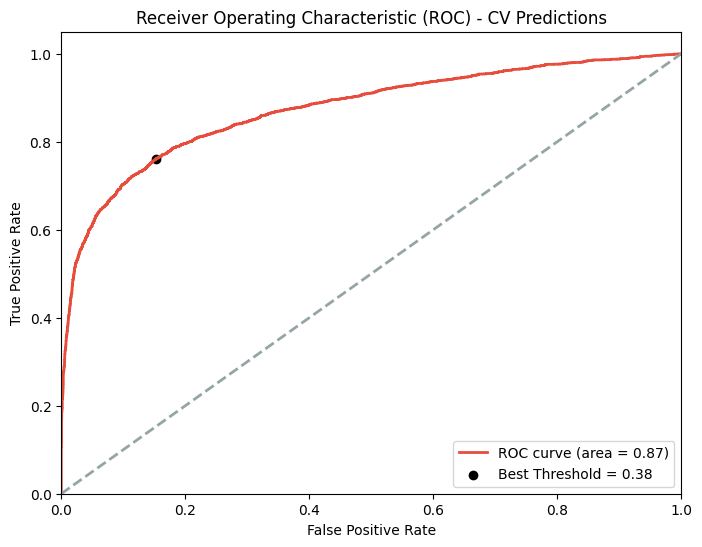

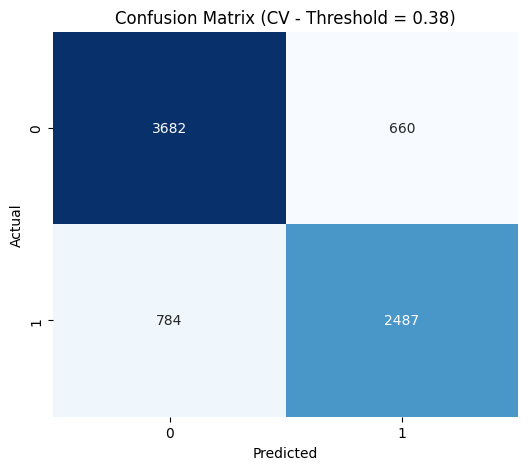

C:\Users\maxim\AppData\Local\Temp\ipykernel_23308\2007780023.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


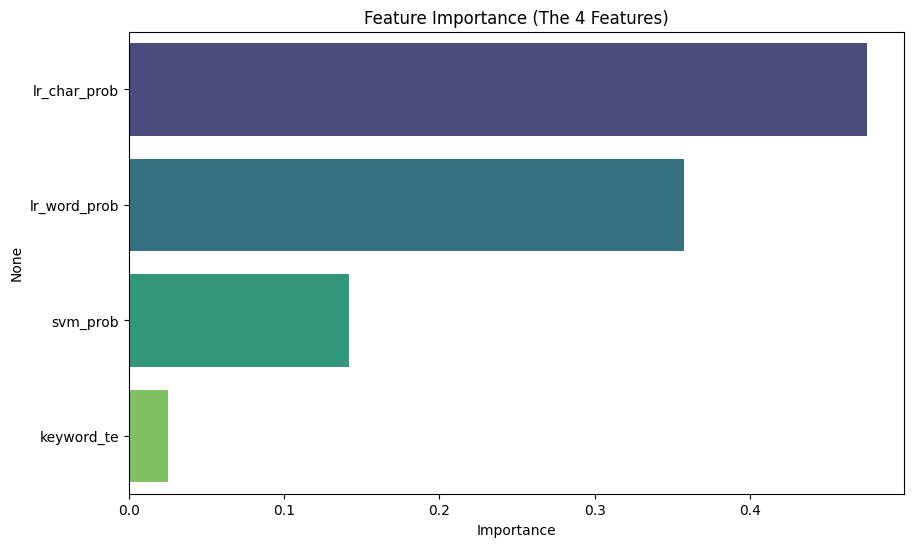

In [7]:
best_model = random_search.best_estimator_

# Como usamos CV para generar las features, el score de CV es una buena estimación.
# Pero para graficar ROC y CM necesitamos predicciones.
# Podemos usar cross_val_predict sobre el modelo final.

y_probs_cv = cross_val_predict(best_model, X_train_meta, y, cv=skf, method='predict_proba')[:, 1]

# 1. Curva ROC
fpr, tpr, thresholds = roc_curve(y, y_probs_cv)
roc_auc = auc(fpr, tpr)

# Mejor threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold: {best_thresh:.4f}')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLOR_DISASTER, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=COLOR_GENERAL, lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - CV Predictions')
plt.legend(loc="lower right")
plt.show()

# 2. Matriz de Confusión
y_pred_opt = (y_probs_cv > best_thresh).astype(int)
cm = confusion_matrix(y, y_pred_opt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (CV - Threshold = {best_thresh:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. Feature Importance
importances = best_model.feature_importances_
feature_names = X_train_meta.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Feature Importance (The 4 Features)")
plt.xlabel("Importance")
plt.show()

## Submission

In [8]:
# Re-entrenar con todo el dataset
best_model.fit(X_train_meta, y)

# Predecir en test
y_probs_sub = best_model.predict_proba(X_test_meta)[:, 1]
y_pred_sub = (y_probs_sub > best_thresh).astype(int)

submission = pd.DataFrame({'id': test_df['id'], 'target': y_pred_sub})

submission_path = pathlib.Path("../.data/submission")
submission_path.mkdir(parents=True, exist_ok=True)
submission.to_csv(submission_path / "4feats_submission.csv", index=False)

print(f"Submission guardada en {submission_path / '4feats_submission.csv'}")

Submission guardada en ..\.data\submission\4feats_submission.csv
